# Diagnóstico y Corrección de las Hipótesis del Modelo Lineal Múltiple

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

data = sm.datasets.macrodata.load_pandas().data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


- year      - 1959q1 - 2009q3
- quarter   - 1-4
- realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
            seasonally adjusted annual rate)
- realcons  - Real personal consumption expenditures (Bil. of chained
            2005 US$, seasonally adjusted annual rate)
- realinv   - Real gross private domestic investment (Bil. of chained
            2005 US$, seasonally adjusted annual rate)
- realgovt  - Real federal consumption expenditures & gross investment
            (Bil. of chained 2005 US$, seasonally adjusted annual rate)
- realdpi   - Real private disposable income (Bil. of chained 2005
            US$, seasonally adjusted annual rate)
- cpi       - End of the quarter consumer price index for all urban
            consumers: all items (1982-84 = 100, seasonally adjusted).
- m1        - End of the quarter M1 nominal money stock (Seasonally
            adjusted)
- tbilrate  - Quarterly monthly average of the monthly 3-month
            treasury bill: secondary market rate
- unemp     - Seasonally adjusted unemployment rate (%)
- pop       - End of the quarter total population: all ages incl. armed
            forces over seas
- infl      - Inflation rate (ln(cpi_{t}/cpi_{t-1}) * 400)
- realint   - Real interest rate (tbilrate - infl)

In [2]:
y = data['realgdp']
X = data[['realcons', 'realinv', 'unemp']]
X = sm.add_constant(X)

modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                realgdp   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.621e+04
Date:                Sun, 30 Nov 2025   Prob (F-statistic):          1.29e-282
Time:                        18:00:24   Log-Likelihood:                -1262.3
No. Observations:                 203   AIC:                             2533.
Df Residuals:                     199   BIC:                             2546.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        601.6099     42.748     14.074      0.0

## Normalidad

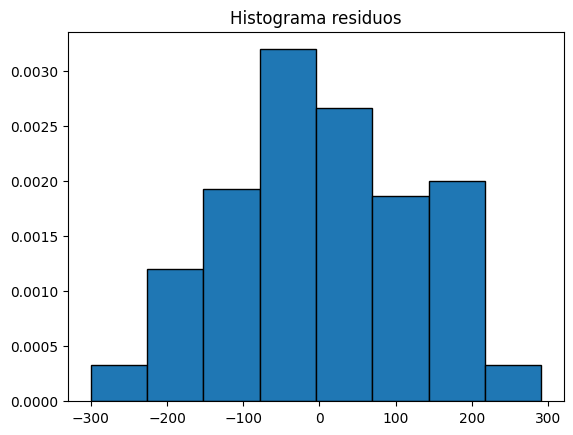

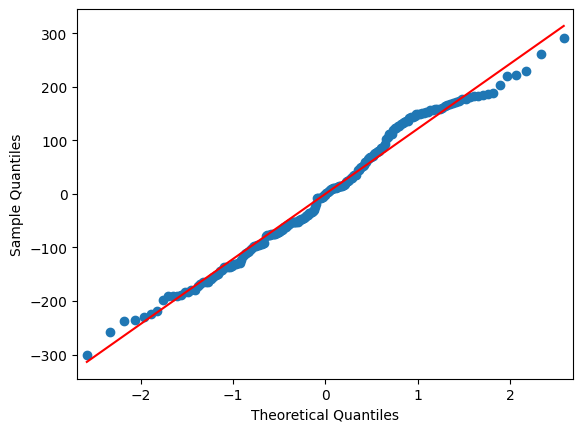

KstestResult(statistic=np.float64(0.07019772765399812), pvalue=np.float64(0.2575723985609766), statistic_location=np.float64(1.009350612321497), statistic_sign=np.int8(-1))

In [3]:
resid = modelo.resid
resid_std = (resid - resid.mean())/resid.std(ddof=1)

plt.hist(resid, bins=8, edgecolor='black', density=True)
plt.title('Histograma residuos')
plt.show()

sm.qqplot(resid, line='s')
plt.show()

stats.kstest(resid_std, 'norm')

## Multicolinealidad

In [4]:
vif = pd.DataFrame()
vif['var']=X.columns
vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif

,var,VIF
0,const,24.665794
1,realcons,32.540033
2,realinv,33.591369
3,unemp,1.578993


In [5]:
cond=np.linalg.cond(X.values.T@X.values)
np.sqrt(cond)

np.float64(27470.939248297887)

## Heteroscedasticidad

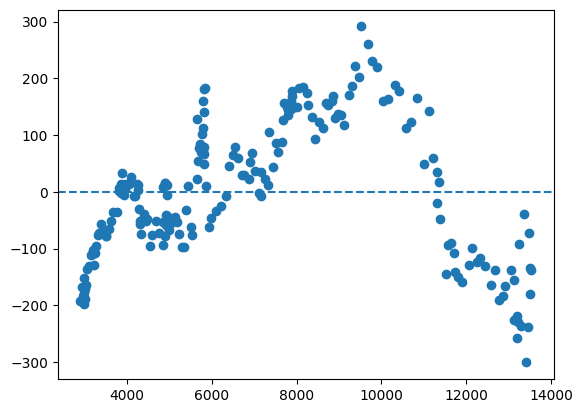

In [6]:
fitted = modelo.fittedvalues
plt.scatter(fitted, resid); plt.axhline(0,ls='--'); plt.show()

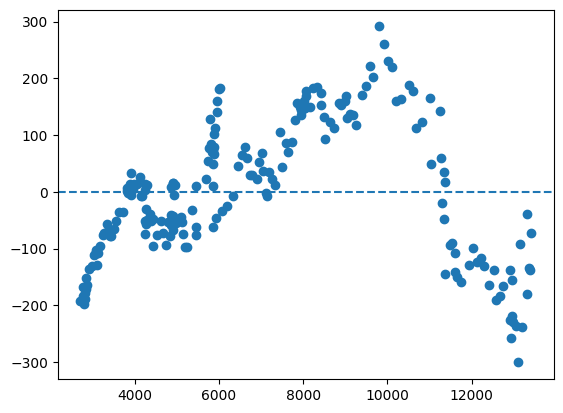

In [7]:
plt.scatter(data['realgdp'], resid); plt.axhline(0,ls='--'); plt.show()

In [8]:
sms.het_goldfeldquandt(y,X)

(np.float64(3.182952142715069),
 np.float64(1.3557180472455934e-08),
 'increasing')

In [9]:
sms.het_breuschpagan(resid,X)

(np.float64(43.404019612915064),
 np.float64(2.019867587648515e-09),
 np.float64(18.04013668769707),
 np.float64(2.1408273519585702e-10))

In [10]:
sms.het_white(resid,X)

(np.float64(66.88804513878127),
 np.float64(6.185082156536262e-11),
 np.float64(10.5382144385377),
 np.float64(3.2170623301561893e-13))

In [11]:
glejser_y = np.abs(resid)

for v in ['realcons', 'realinv']:
    print(f"Variable {v}:")
    for h in [-3, -2, -1, 1, 2, 3]:
        z = X[v]**h
        Z = pd.DataFrame({'zvar': z})
        
        glejser = sm.OLS(glejser_y, sm.add_constant(Z)).fit()
        
        pval = glejser.pvalues['zvar']
        print(f"\t p-valor {v}^{h}: {pval}. R^2: {glejser.rsquared}")

Variable realcons:
	 p-valor realcons^-3: 0.50870569134923. R^2: 0.002175818910750027
	 p-valor realcons^-2: 0.023185842996592793. R^2: 0.025380508595764018
	 p-valor realcons^-1: 3.0398437743070073e-05. R^2: 0.08308913559697373
	 p-valor realcons^1: 2.6801528838948243e-12. R^2: 0.2164542138465816
	 p-valor realcons^2: 4.3286759490954927e-13. R^2: 0.230312655471142
	 p-valor realcons^3: 2.0684854465332222e-12. R^2: 0.21843736518459744
Variable realinv:
	 p-valor realinv^-3: 0.43652600377383066. R^2: 0.003014873870154422
	 p-valor realinv^-2: 0.31754471885168123. R^2: 0.004970292284085409
	 p-valor realinv^-1: 0.0008884305636815144. R^2: 0.05360493557480195
	 p-valor realinv^1: 7.2302582013226e-11. R^2: 0.19082413206059956
	 p-valor realinv^2: 8.82645210969651e-11. R^2: 0.1892483077002537
	 p-valor realinv^3: 1.2530863098665675e-09. R^2: 0.16802867519424736


### Mínimos Cuadrados Ponderados

In [12]:
weights = 1/data['realcons']
wls_results = sm.WLS(y,X,weights=weights).fit()
wls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                realgdp   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.808e+04
Date:                Sun, 30 Nov 2025   Prob (F-statistic):          2.51e-284
Time:                        18:00:24   Log-Likelihood:                -1242.9
No. Observations:                 203   AIC:                             2494.
Df Residuals:                     199   BIC:                             2507.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        524.2057     32.803     15.981      0.000     459.520     588.891
realcons       1.3841      0.023     60.232      0.000       1.339       1.429
realinv        0.0887      0.093      0.954      0.341      -0.095       0.272
unemp        -12.1855      6.158     -1.979      0.049     -24.330      -0.041
==============================================================================
Omnibus:                       11.971   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                8.861
Skew:                          -0.399   Prob(JB):                       0.0119
Kurtosis:                       2.359   Cond. No.                     1.97e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Autocorrelación

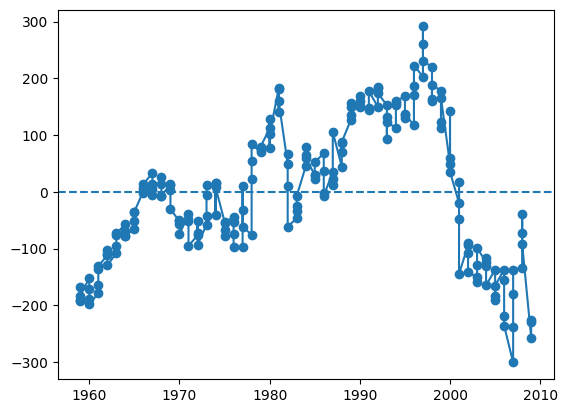

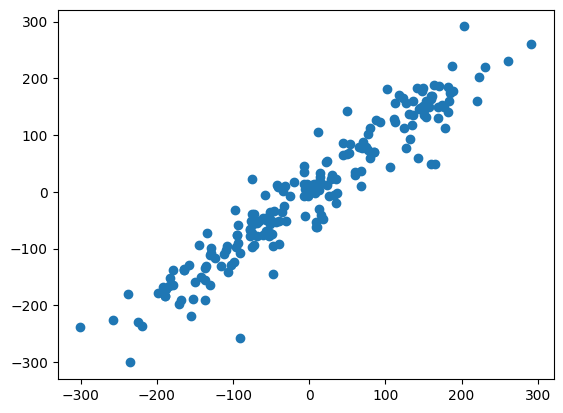

np.float64(0.09400367570822646)

In [14]:
plt.plot(data['year'], modelo.resid, marker='o'); plt.axhline(0,ls='--'); plt.show()

plt.scatter(modelo.resid[:-1], modelo.resid[1:]); plt.show()

durbin_watson(modelo.resid)

In [15]:
acorr_ljungbox(modelo.resid,lags=[1,2,3,4,5],return_df=True)

,lb_stat,lb_pvalue
1,181.306840,2.512406e-41
2,345.524522,9.339066e-76
3,492.982350,1.582985e-106
4,628.105247,1.279563e-134
5,753.145303,1.579215e-160


## Prais-Winsten

In [ ]:
dw = durbin_watson(modelo.resid)
rho = 1 - (dw/2)

mco_autocorr=sm.GLSAR(y, sm.add_constant(X), rho=rho)
res=mco_autocorr.iterative_fit(maxiter=100,rtol=10**(-10))


print ('Iteraciones = %d Converge: %s' % (res.iter, res.converged) )
print ('Rho =  ', mco_autocorr.rho)
print(res.summary())

Iteraciones = 15 Converge: True
Rho =   [0.97648506]
                           GLSAR Regression Results                           
Dep. Variable:                realgdp   R-squared:                       0.944
Model:                          GLSAR   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1114.
Date:                Sun, 30 Nov 2025   Prob (F-statistic):          1.19e-123
Time:                        18:00:25   Log-Likelihood:                -931.91
No. Observations:                 202   AIC:                             1872.
Df Residuals:                     198   BIC:                             1885.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------